In [1]:
# on-set = { 011, 101, 110 }, n_iteration = 1
# f = (x1x2x3)'(x1'x2')'(x1'x3')'(x2'x3')'
from qiskit import *
import numpy as np
%matplotlib inline

# num of anci_bits >= num of control_bits - 2
def MCT(qc, control_bits, target_bit, anci_bits):
    anci_idx = 0
    qc.ccx(control_bits[0], control_bits[1], anci_bits[anci_idx])
    for idx in range(2, len(control_bits) - 1):
        qc.ccx(control_bits[idx], anci_bits[anci_idx], anci_bits[anci_idx + 1])
        anci_idx += 1
    qc.ccx(control_bits[len(control_bits) - 1], anci_bits[anci_idx], target_bit)
    for idx in reversed(range(2, len(control_bits) - 1)):
        qc.ccx(control_bits[idx], anci_bits[anci_idx - 1], anci_bits[anci_idx])
        anci_idx -= 1
    qc.ccx(control_bits[0], control_bits[1], anci_bits[anci_idx])

def initialize(cir):
    cir.x(1)
    cir.x(2)
    cir.x(3)
    cir.h(1)
    cir.h(2)
    cir.h(3)

def oracle(cir):
    # computation
    MCT(cir, range(1, 4), 4, range(8, 10)) # clause C1'= (x1x2x3)
    cir.x(1)
    cir.x(2)
    cir.ccx(1, 2, 5) # clause C2'= (x1'x2')
    cir.x(3)
    cir.ccx(1, 3, 6) # clause C3'= (x1'x3')
    cir.ccx(2, 3, 7) # clause C4'= (x2'x3')
    cir.x(4) # C1
    cir.x(5) # C2
    cir.x(6) # C3
    cir.x(7) # C4
    MCT(cir, range(4, 8), 0, range(8, 10)) # f = C1^C2^C3^C4
    cir.z(0)
    # uncomputation
    MCT(cir, range(4, 8), 0, range(8, 10))
    cir.x(4)
    cir.x(5)
    cir.x(6)
    cir.x(7)
    cir.ccx(2, 3, 7)
    cir.ccx(1, 3, 6)
    cir.x(3)
    cir.ccx(1, 2, 5)
    cir.x(1)
    cir.x(2)
    MCT(cir, range(1, 4), 4, range(8, 10))

def diffusion(cir):
    cir.h(1)
    cir.h(2)
    cir.ccx(1, 2, 3)
    cir.h(1)
    cir.h(2)

n_iterations = 1
cir = QuantumCircuit(10, 3) # 0: result qubit, 1~3: vars, 4~7: clauses, 8~9: mct ancillary
initialize(cir)
for i in range(n_iterations):
    oracle(cir)
    diffusion(cir)

cir.barrier(range(1, 4))
cir.measure(range(1, 4), range(0, 3))
cir.draw()

{'011': 253, '000': 25, '101': 335, '110': 286, '010': 31, '001': 36, '111': 31, '100': 27}


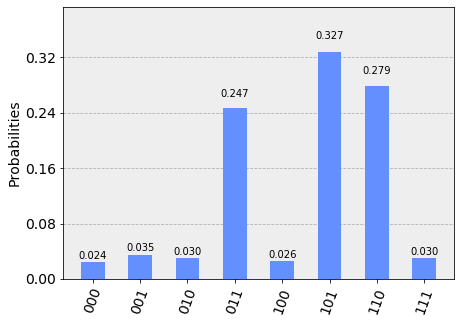

In [2]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(cir, simulator, shots = 1024)
result = job.result()

counts = result.get_counts(cir)
print(counts)
visualization.plot_histogram(counts)